In [1]:
rm(list=ls())
setwd("/hpc/group/pbenfeylab/CheWei/")

In [2]:
suppressMessages(library(Matrix))
suppressMessages(library(DropletUtils))
suppressMessages(library(ggplot2))
suppressMessages(library(scales))
suppressMessages(library(rjson))
suppressMessages(library(R2HTML))
suppressMessages(library(zeallot))
suppressMessages(library(Seurat))
suppressMessages(library(tidyverse))
suppressMessages(library(rhdf5))
suppressMessages(library(grid))

In [3]:
source("/hpc/group/pbenfeylab/CheWei/COPILOT_other_projects/COPILOT_functions_HT.R")

In [4]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.6 (Sage Margay)

Matrix products: default
BLAS/LAPACK: /hpc/group/pbenfeylab/ch416/miniconda3/envs/seu4/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] rhdf5_2.42.1                forcats_0.5.2              
 [3] stringr_1.5.1               dplyr_1.1.3                
 [5] purrr_1.0.2                 readr_2.1.3                
 [7] tidyr_1.3.0                 tibble_3.2.1               
 [9] tidyverse

## Load the unfiltered mtx 

In [5]:
## Output of the read aligner like STAR or kallisto. STAR is implemented by 10X genomics cellranger, so if you run cellranger, provide the unfiltered matrix here.  
mtx <- readMM("./Raw_mtx/raw_feature_bc_matrix/matrix.mtx.gz")
bcs <- read.table("./Raw_mtx/raw_feature_bc_matrix/barcodes.tsv.gz")
fea <- read.table("./Raw_mtx/raw_feature_bc_matrix/features.tsv.gz")

In [6]:
rownames(mtx) <- fea$V1
colnames(mtx) <- bcs$V1

## Set the filtering parameters

In [7]:
min.UMI.low.quality = 10 ## Lowest threshold for barcodes to be considered not empty
min.UMI.high.quality = 100 ## Lowest threshold for barcodes to be considered high quality
mt.pattern = "MT:gene" ## Shared strings of mitochondrial genes or proxy of genes for noise. Alternatively, you can provide list of genes. 
mt.threshold = 5 ## Threshold of noise gene expression level used to identity initial low quality cell population 
filtering.ratio = 0 ## Whether to iterate: 1 = no iteration, 0 = iterate until converge
legend.position = c(0.8,0.8) ## plotting parameters
top.percent= 1 ## Percentage of upper end outlier removed
## Information of your sample
species.name = "Solanum lycopersicum" 
transcriptome.name = "SL4.0"
sample.name = "S1"

## Start COPILOT filtering

In [8]:
# Prefiltering
bcs_use <- colnames(mtx) ## Barcodes to use
tot_genes <- Matrix::rowSums(mtx) ## Total counts per gene
genes_use <- rownames(mtx)[tot_genes > 0] ## Identify genes that have no counts
afr <- mtx[genes_use, bcs_use] ## Remove genes that have no counts and unwanted barcodes
tot_gene <- Matrix::colSums(afr) ## Total UMI counts per cell
bcs_use <- colnames(afr)[tot_gene > min.UMI.low.quality] ## Identify barcodes having total UMI counts per cell higher than min.UMI.low.quality
afr <- mtx[genes_use, bcs_use]

In [9]:
# Gather basic information
nc <- colSums(afr) ## Total number of UMI counts per cell
ng <- colSums(afr>0) ## Total number of genes per cell
lnc <- log10(nc) ## Log(Total number of UMI counts per cell)
pmt <- (colSums(afr[grep(paste(mt.pattern, collapse = "|"),rownames(afr)),])/nc)*100 # Calculate mt/noise expression proportion
lnc.mt <- lnc[pmt >= mt.threshold] ## Identify the Log(Total number of UMI counts per cell) for those barcodes having elevated mt/noise expression proportion

In [10]:
## Identify initial threshold for noise
if (length(lnc.mt)==0){ ## No barcodes having elevated elevated mt/noise expression proportion
  mmt <- log10(min.UMI.high.quality)# If no high mt cell, then set the first filtering threshold at min UMI counts threshold         
} else if (length(lnc.mt)==1) {
  mmt <- lnc.mt # log10 mean UMI counts for cells above threshold
} else {
  dd <- density(lnc.mt)
  mmt <- max(dd$x[find_modes(dd$y)][dd$x[find_modes(dd$y)] < max(boxplot.stats(lnc.mt)$stats)]) # find the maximum mode
}

In [14]:
# COPILOT
lcu <- as.numeric(log10(cumsum(rev(sort(nc))))) # log culmulative UMI counts
snc <- as.numeric(rev(sort(nc))) # sorted UMI counts
lin <- log10(seq(1,ncol(afr),1))
dYu <- diff(lcu)/diff(lin)  # the derivative  
dX <- rowMeans(embed(lin,2)) # centers the X values for plotting
local_min <- min(dYu[1:(length(which(lnc>mmt))-1)]) #local min derivative
cnu <- which(dYu<=local_min)[1] ## cell barcode position where the local min is
if (snc[cnu] < min.UMI.high.quality){
  cnu <- length(which(nc > min.UMI.high.quality))# If no local minimum, then set the first filtering threshold at min UMI counts threshold  
}

ct <- sort(nc,decreasing = TRUE)[cnu] # UMI threshold at elbow point 

# Filtering on UMI counts (first round)
filter.UMI.thres.n=c(min.UMI.low.quality,ct)
filter.UMI.thres=c(ct,1000000)
nf <- afr[,(colSums(afr) > filter.UMI.thres.n[1])&(colSums(afr) <= filter.UMI.thres.n[2])] # lower quality cells
af <- afr[,(colSums(afr) > filter.UMI.thres[1])&(colSums(afr) < filter.UMI.thres[2])] # higher quality cells
nnf <- log1p((nf/colSums(nf))*10000) #log normalization
naf <- log1p((af/colSums(af))*10000) #log normalization
np <- rowSums(nnf)/ncol(nnf) # low quality cell profile
sp <- rowSums(naf)/ncol(naf) # high quality cell profile

cornp <- apply(naf,2,cor,y=np)
corsp <- apply(naf,2,cor,y=sp)

sidx <- c()
nidx <- c()
for (i in 1:ncol(af)){
  if (corsp[i] > cornp[i]){
    sidx <- c(sidx, i)
  } else {
    nidx <- c(nidx, i)
  }
}

#Decide filtering threshold: lenient: 1, strict:0, moderate: 0 < filtering.ratio < 1
nidx_thres <- length(nidx)*filtering.ratio #moderate
print(paste0("threshold cell number: ",nidx_thres))
n_iteration <- 0
print(paste0("removed cells: ",length(nidx)))
while(length(nidx)!=0 & length(nidx) >= nidx_thres){
  n_iteration <- n_iteration+1 
  #nf <- cbind(nf,afr[,colnames(af)[nidx]])
  nf <- cbind(nf,afr[,which(colnames(afr) %in% colnames(af)[nidx])])
  #af <- afr[,colnames(af)[sidx]]
  af <- afr[,which(colnames(afr) %in% colnames(af)[sidx])]
  nnf <- log1p((nf/colSums(nf))*10000) #log normalization
  naf <- log1p((af/colSums(af))*10000) #log normalization
  np <- rowSums(nnf)/ncol(nnf) # low quality cell profile
  sp <- rowSums(naf)/ncol(naf) # high quality cell profile
  cornp <- apply(naf,2,cor,y=np)
  corsp <- apply(naf,2,cor,y=sp)   
  sidx <- c()
  nidx <- c()
  for (i in 1:ncol(af)){            
    if (corsp[i] > cornp[i]){                
      sidx <- c(sidx, i)
    } else {                
      nidx <- c(nidx, i)
    }
  }
  print(paste0("iteration: ",n_iteration))
  print(paste0("removed cells: ",length(nidx)))
}
message("Iteration finished")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 34.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 34.7 GiB”


[1] "threshold cell number: 0"
[1] "removed cells: 11951"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 32.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 32.3 GiB”


[1] "iteration: 1"
[1] "removed cells: 97999"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 12.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 12.3 GiB”


[1] "iteration: 2"
[1] "removed cells: 41877"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.8 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.8 GiB”


[1] "iteration: 3"
[1] "removed cells: 3427"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.1 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.1 GiB”


[1] "iteration: 4"
[1] "removed cells: 664"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.9 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.9 GiB”


[1] "iteration: 5"
[1] "removed cells: 367"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.9 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.9 GiB”


[1] "iteration: 6"
[1] "removed cells: 279"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.8 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.8 GiB”


[1] "iteration: 7"
[1] "removed cells: 227"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


[1] "iteration: 8"
[1] "removed cells: 218"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


[1] "iteration: 9"
[1] "removed cells: 199"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.7 GiB”


[1] "iteration: 10"
[1] "removed cells: 178"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”


[1] "iteration: 11"
[1] "removed cells: 136"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”


[1] "iteration: 12"
[1] "removed cells: 97"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”


[1] "iteration: 13"
[1] "removed cells: 1"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”


[1] "iteration: 14"
[1] "removed cells: 95"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”


[1] "iteration: 15"
[1] "removed cells: 75"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


[1] "iteration: 16"
[1] "removed cells: 75"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


[1] "iteration: 17"
[1] "removed cells: 65"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


[1] "iteration: 18"
[1] "removed cells: 53"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


[1] "iteration: 19"
[1] "removed cells: 46"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


[1] "iteration: 20"
[1] "removed cells: 38"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


[1] "iteration: 21"
[1] "removed cells: 41"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


[1] "iteration: 22"
[1] "removed cells: 44"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


[1] "iteration: 23"
[1] "removed cells: 53"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


[1] "iteration: 24"
[1] "removed cells: 46"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


[1] "iteration: 25"
[1] "removed cells: 43"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 26"
[1] "removed cells: 41"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 27"
[1] "removed cells: 29"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 28"
[1] "removed cells: 31"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 29"
[1] "removed cells: 30"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 30"
[1] "removed cells: 26"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 31"
[1] "removed cells: 24"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 32"
[1] "removed cells: 35"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 33"
[1] "removed cells: 21"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 34"
[1] "removed cells: 20"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 35"
[1] "removed cells: 20"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 36"
[1] "removed cells: 12"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 37"
[1] "removed cells: 16"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 38"
[1] "removed cells: 14"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 39"
[1] "removed cells: 13"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 40"
[1] "removed cells: 17"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 41"
[1] "removed cells: 17"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 42"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 43"
[1] "removed cells: 10"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 44"
[1] "removed cells: 12"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 45"
[1] "removed cells: 13"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 46"
[1] "removed cells: 7"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 47"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 48"
[1] "removed cells: 6"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 49"
[1] "removed cells: 7"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 50"
[1] "removed cells: 7"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 51"
[1] "removed cells: 3"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 52"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”


[1] "iteration: 53"
[1] "removed cells: 9"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 54"
[1] "removed cells: 7"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 55"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 56"
[1] "removed cells: 7"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 57"
[1] "removed cells: 7"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 58"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 59"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 60"
[1] "removed cells: 9"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 61"
[1] "removed cells: 6"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 62"
[1] "removed cells: 6"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 63"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 64"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 65"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 66"
[1] "removed cells: 6"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 67"
[1] "removed cells: 7"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 68"
[1] "removed cells: 1"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 69"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 70"
[1] "removed cells: 9"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 71"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 72"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 73"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 74"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 75"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 76"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 77"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 78"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 79"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 80"
[1] "removed cells: 3"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 81"
[1] "removed cells: 3"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 82"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 83"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 84"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 85"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 86"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 87"
[1] "removed cells: 8"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 88"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 89"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 90"
[1] "removed cells: 3"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 91"
[1] "removed cells: 1"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 92"
[1] "removed cells: 3"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 93"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 94"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 95"
[1] "removed cells: 1"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 96"
[1] "removed cells: 3"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 97"
[1] "removed cells: 3"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 98"
[1] "removed cells: 3"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 99"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 100"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 101"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 102"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 103"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 104"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 105"
[1] "removed cells: 3"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 106"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 107"
[1] "removed cells: 5"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 108"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 109"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 110"
[1] "removed cells: 6"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 111"
[1] "removed cells: 3"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 112"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 113"
[1] "removed cells: 1"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 114"
[1] "removed cells: 2"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 115"
[1] "removed cells: 1"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 116"
[1] "removed cells: 4"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


[1] "iteration: 117"
[1] "removed cells: 0"


Iteration finished



## Prepare data for COPILOT summary files

In [15]:
#prepare data.frame for ggplot2
nc <- colSums(af)
ng <- colSums(af>0)
lnc <- log10(nc)
lng <-log10(ng)
pmts <- (colSums(af[grep(paste(mt.pattern, collapse = "|"),rownames(af)),])/nc)*100 # percent mt for high quality cell
ncn <- colSums(nf)
ngn <- colSums(nf>0)
lncn <- log10(ncn)
lngn <- log10(ngn)
pmtn <- (colSums(nf[grep(paste(mt.pattern, collapse = "|"),rownames(nf)),])/ncn)*100 # percent mt for low quality cell

In [16]:
select <- rep(paste("high quality"),length(lnc))
label_mt <- paste0("percent mt >= ",mt.threshold)
select[which(pmts >= mt.threshold)] <- label_mt # index of percent mt > mt.threshold
quantile_idx <- which(lnc < quantile(lnc[which(select=="high quality")],probs = (1-top.percent/100))) # quantile top 1 % tail to determine outliers
ssidx <- intersect(quantile_idx, which(select=="high quality")) # index of final high quality cell
select[ssidx] <- paste("high quality (",length(ssidx),")",sep="")
select[which(select=="high quality")] <- paste("top ",top.percent,"% (",length(which(select=="high quality")),")",sep="")
nonselect <- rep("low quality",length(lncn))
nonselect[which(pmtn >= mt.threshold)] <- label_mt # index of percent mt > mt.threshold
select <- c(select,nonselect)
select[which(select==label_mt)] <- paste("percent mt >= ",mt.threshold," (",length(which(select==label_mt)),")",sep="")
select[which(select=="low quality")] <- paste0("low quality (",length(which(select=="low quality")),")")
lncc <- c(lnc,lncn)
lngc <- c(lng,lngn)
lnc_gg <- data.frame(select=select,lnc=lncc)
lnc_gg$rank <- match(lnc_gg$lnc,sort(lnc_gg$lnc,decreasing = TRUE))
lnc_gg$lnc <- 10^lnc_gg$lnc
lnc_gg$select <- factor(lnc_gg$select, levels = c(paste0("high quality (",length(grep("high",select)),")"), 
                                                  paste0("low quality (",length(grep("low",select)),")"),
                                                  paste0("percent mt >= ",mt.threshold," (",length(grep("percent",select)),")"),
                                                  paste0("top ",top.percent,"% (",length(grep("top",select)),")")))
lng_gg <- data.frame(select=select,lng=lngc)
lng_gg$rank <- match(lng_gg$lng,sort(lng_gg$lng,decreasing = TRUE))
lng_gg$lng <- 10^lng_gg$lng
lng_gg$select <- factor(lng_gg$select, levels = c(paste0("high quality (",length(grep("high",select)),")"), 
                                                  paste0("low quality (",length(grep("low",select)),")"),
                                                  paste0("percent mt >= ",mt.threshold," (",length(grep("percent",select)),")"),
                                                  paste0("top ",top.percent,"% (",length(grep("top",select)),")")))

af <- af[,ssidx]

In [17]:
## Seq stats
seq_stats <- data.frame(stat = c('Number of Reads Processed', 'Reads Pseudoaligned', 'Reads on Whitelist', 'Total UMI Counts','Sequencing Technology', 'Species', 'Transcriptome'), 
                            value = prettyNum(c("Not Provided", "Not Provided", "Not Provided", sum(afr), "Not Provided", species.name, transcriptome.name), big.mark = ','))

In [18]:
## Cell stats
p_cnts_in_cells <- round((sum(af)/sum(afr))*100, 2) # calculate cell stats and save to df
med_cnts_cell <- median(colSums(af))
med_genes_cell <- median(apply(af, 2, function(x) sum(x >= 1)))
tot_genes_detected <- sum(rowSums(af)>=1)
if (length(table(lnc_gg$select)[grep("mt",names(table(lnc_gg$select)))]) == 0){
  p_cnts_dying <- 0
} else {
  p_cnts_dying <- as.numeric(round(table(lnc_gg$select)[grep("mt",names(table(lnc_gg$select)))]/nrow(lnc_gg)*100,2)) 
}
p_cnts_high <-  as.numeric(round(table(lnc_gg$select)[grep("high",names(table(lnc_gg$select)))]/nrow(lnc_gg)*100,2))
cell_stats <- data.frame(stat = c('Estimated Number of High Quality Cell', 'High Quality Cell', 'Total UMI Counts in High Quality Cell','UMI Counts in High Quality Cell',
                                  'Median UMI Counts per High Quality Cell', 'Median Genes per High Quality Cell', 'Total Genes Detected in High Quality Cell'
                                  ,'Cell above Mitochondrial Expression Threshold'), 
                         value = prettyNum(c(ncol(af), paste0(p_cnts_high,' %'), sum(af), paste0(p_cnts_in_cells,' %'), med_cnts_cell,
                                             med_genes_cell, tot_genes_detected, paste0(p_cnts_dying,' %')), big.mark = ','))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


In [19]:
## Parameters used
parameters <- data.frame(para = c('Iteration of Filtering', 'Mitochondrial Expression Threshold', 'Top High Quality Cell Filtered', 'Expected Doublet Rate in High Quality Cell', 'Doublet Removed'), 
                               value = c(n_iteration,paste0(mt.threshold,' %'),paste0(top.percent,' %'),'No estimation', 'No'))

In [20]:
## Plots                              
bc_rank_plot(lnc_gg=lnc_gg, save = "./Raw_mtx/raw_feature_bc_matrix/bc_rank_plot.png")
UMI_hist_plot(lnc_gg=lnc_gg, save = "./Raw_mtx/raw_feature_bc_matrix/UMI_hist_plot.png", legend.position=legend.position)
Gene_hist_plot(lng_gg=lng_gg, save = "./Raw_mtx/raw_feature_bc_matrix/Gene_hist_plot.png")

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.”


png 
  2

png 
  2

png 
  2

In [21]:
#Output html 
print_HTML_no_analysis(parameters = parameters, cell_stats = cell_stats, seq_stats = seq_stats, sample_stats = NULL, dir = "./Raw_mtx/raw_feature_bc_matrix/", sample.name = sample.name)

In [22]:
#Save filtered raw counts
write10xCounts('./Raw_mtx/raw_feature_bc_matrix/counts_filtered', af, overwrite=T)

## Seurat (Optional)

In [23]:
seu <- CreateSeuratObject(counts = af, assay = "RNA")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [24]:
# SCTransform normalization using "all the genes/features", notice that we do not perform selection of highly variable genes 
suppressWarnings(
seu <- SCTransform(seu, variable.features.n = nrow(seu), assay = "RNA", new.assay.name = "SCT", verbose = FALSE)
)

In [25]:
# Run PCA
seu <- RunPCA(seu)

PC_ 1 
Positive:  gene:Solyc07g052510.4, gene:Solyc11g069430.2, gene:Solyc03g120470.4, gene:Solyc08g081190.3, gene:Solyc09g075890.3, gene:Solyc08g079190.2, gene:Solyc12g056220.2, gene:Solyc11g012325.1, gene:Solyc08g078870.3, gene:Solyc10g078530.2 
	   gene:Solyc08g078930.1, gene:Solyc06g074820.3, gene:Solyc08g008045.1, gene:Solyc03g116060.5, gene:Solyc09g010940.4, gene:Solyc09g007770.3, gene:Solyc08g074682.1, gene:Solyc06g060110.3, gene:Solyc01g109140.3, gene:Solyc02g085730.3 
	   gene:Solyc11g071470.1, gene:Solyc09g007760.5, gene:Solyc03g117980.3, gene:Solyc08g078910.1, gene:Solyc07g049530.3, gene:Solyc07g042170.3, gene:Solyc08g068630.5, gene:Solyc02g086458.2, gene:Solyc06g011350.3, gene:Solyc03g025640.2 
Negative:  gene:Solyc08g074690.3, gene:Solyc09g090005.1, gene:Solyc03g091000.1, gene:Solyc08g066590.3, gene:Solyc11g069280.2, gene:Solyc01g091100.2, gene:Solyc02g076890.1, gene:Solyc01g106600.2, gene:Solyc10g086090.2, gene:Solyc08g082440.3 
	   gene:Solyc05g015300.5, gene:Solyc10g086

In [26]:
# Run UMAP
suppressMessages(suppressWarnings(
  seu <- RunUMAP(seu, reduction = "pca", dims=1:30)
))

In [27]:
# Find nearest neighbors
suppressMessages(suppressWarnings(
  seu <- FindNeighbors(seu, reduction = "pca")
))

In [28]:
# Find clusters, here we choose Leiden clustering algorithm with resolution 0.5. Parameter "algorithm": 1 = original Louvain algorithm; 2 = Louvain algorithm with multilevel refinement; 3 = SLM algorithm; 4 = Leiden algorithm
suppressMessages(suppressWarnings(
  seu <- FindClusters(seu, resolution = 0.5)
))

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11151
Number of edges: 336469

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8849
Number of communities: 12
Elapsed time: 0 seconds


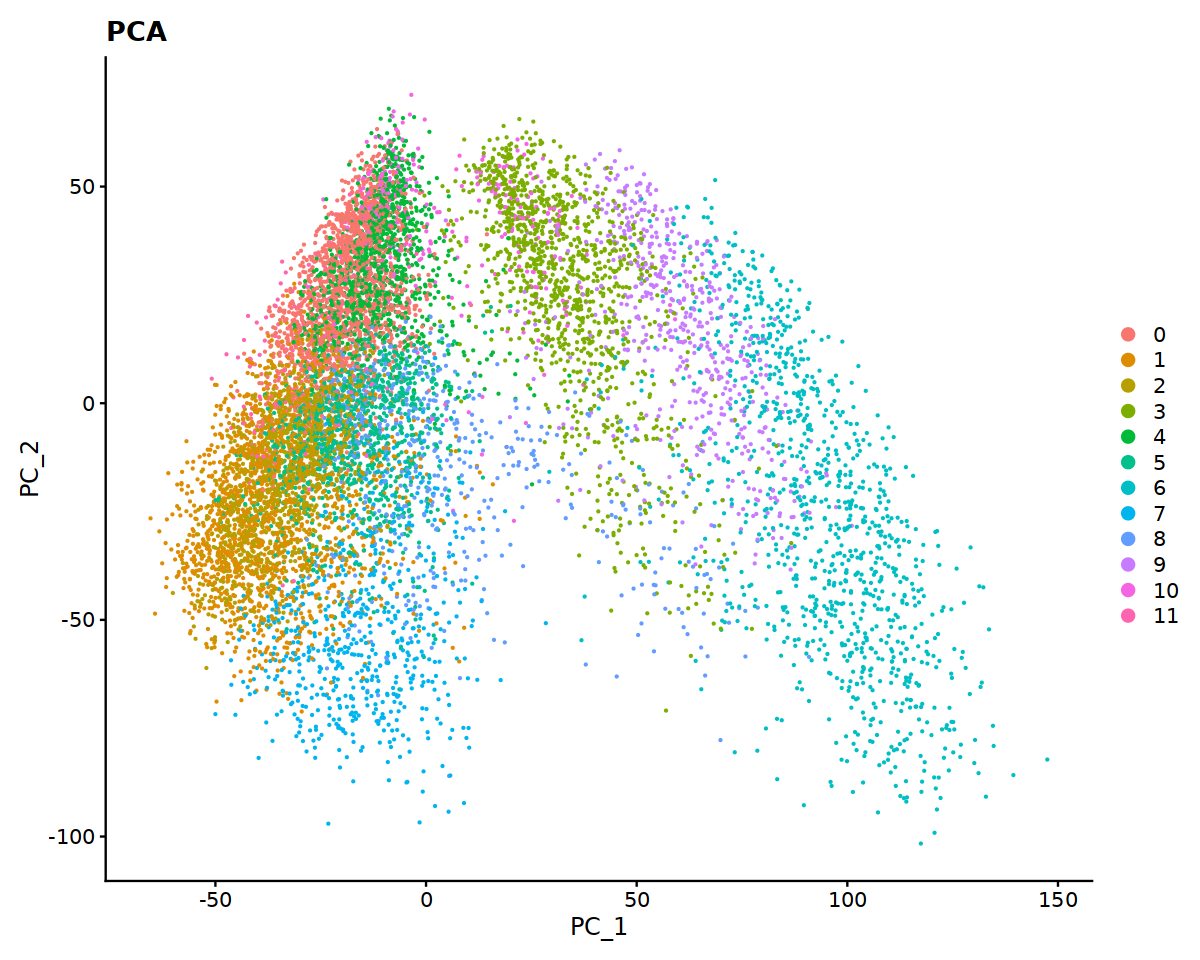

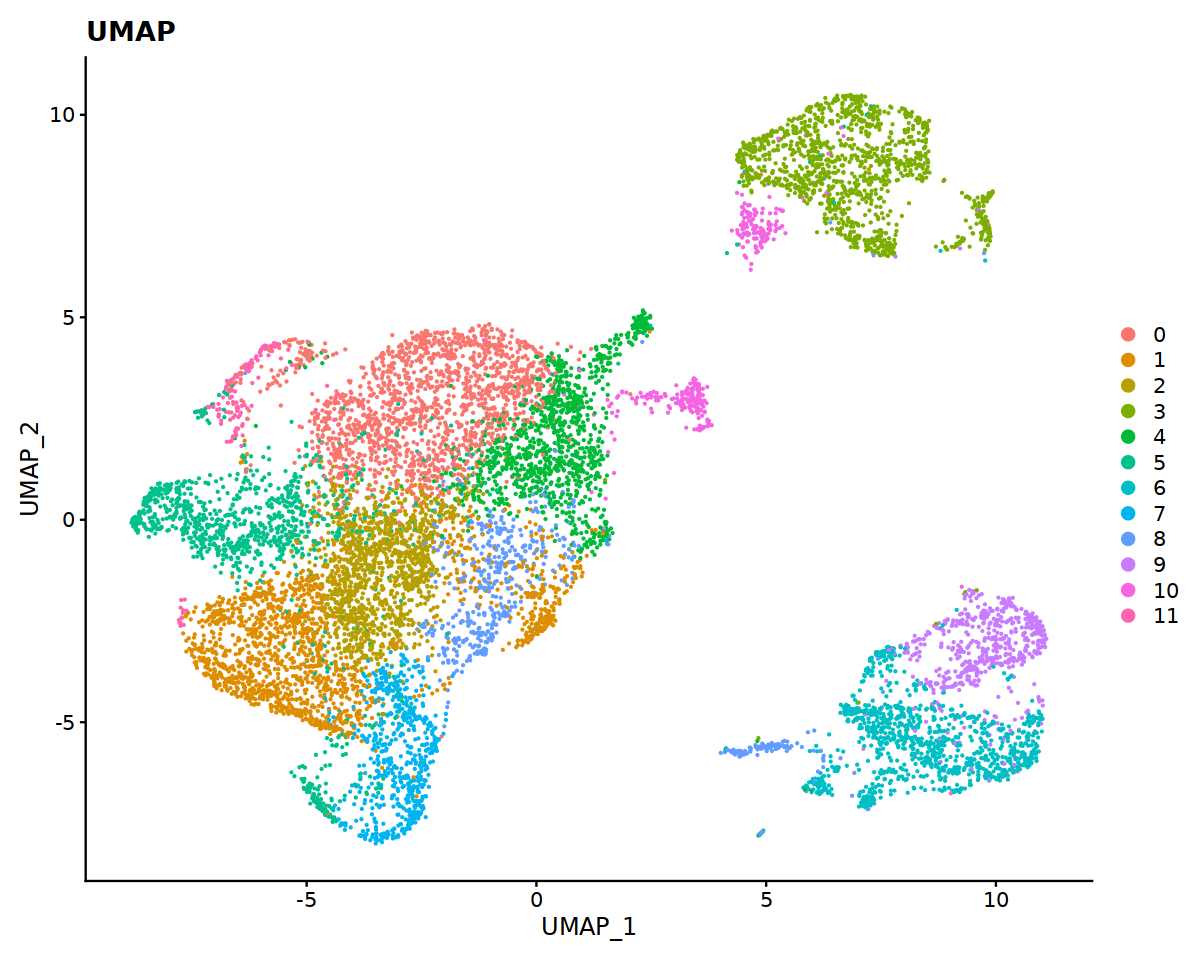

In [29]:
# Correlation-based celltype annotation
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(seu, reduction = "pca")+ggtitle("PCA")
DimPlot(seu, reduction = "umap")+ggtitle("UMAP")

In [30]:
# Save Seurat object
saveRDS(seu, file = "./Raw_mtx/raw_feature_bc_matrix/SL_S1_iteration_117_COPILOT_seu4.rds")